In [ ]:
import random
import pandas as pd
import yaml
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from modeling import ThreeLayerClassifier, sample_model
players = pd.read_csv('C:/Github/nfl_sim/data/depth.csv',
                      usecols=['season', 'club_code', 'week',  'dense_depth','formation', 'gsis_id',
       'position', 'full_name'])
rb_stats =  pd.read_csv('data/team_rb_stats.csv',index_col=0)

In [160]:
model_path = "models/run_yards_gained.pt"
model = ThreeLayerClassifier()
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [161]:
player_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')

players = player_stats[['player_id','week','season', 'fantasy_points_ppr_roll','rushing_yards_roll', 'carries_roll']].merge(players,left_on=['player_id','week','season'],right_on=['gsis_id','week','season'])

In [163]:
player_stats.loc[(player_stats.player_id=='00-0036919') & (player_stats.season==2024)]
# will ship '00-0039746'

,season,team_name,week,game_type,depth_team,last_name,first_name,football_name,formation,gsis_id,...,receiving_air_yards_roll,receiving_tds_roll,receiving_yards_after_catch_roll,passing_tds_roll,sack_yards_roll,rushing_yards_roll,attempts_roll,rushing_first_downs_roll,receiving_yards_roll,rushing_tds_roll
3298,2024,PHI,1.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,-0.794954,9.360642e-08,9.767174,0.0,0.0,9.388164,0.053124,0.627866,8.414289,0.005506
18219,2024,PHI,2.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,-0.567824,6.686173e-08,6.976553,0.0,0.0,8.420117,0.037946,0.448476,6.010206,0.003933
37770,2024,PHI,3.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,2.737269,4.775838e-08,6.411823,0.0,0.0,6.014369,0.027104,0.320340,7.721576,0.002809
42766,2024,PHI,4.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,2.526620,3.411313e-08,4.579874,0.0,0.0,6.867407,0.019360,0.514528,5.515411,0.002007
60886,2024,PHI,5.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,1.804729,2.436652e-08,3.271338,0.0,0.0,4.905291,0.013829,0.367520,3.939580,0.001433
71230,2024,PHI,6.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,-0.139479,1.740466e-08,2.336670,0.0,0.0,10.075208,0.009878,0.548229,2.813985,0.001024
87559,2024,PHI,7.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,1.043229,1.243190e-08,3.669050,0.0,0.0,23.196577,0.007055,1.248735,5.152847,0.000731
98256,2024,PHI,8.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,-0.111979,8.879927e-09,2.620750,0.0,0.0,21.997555,0.005040,1.177668,3.680605,0.000522
101842,2024,PHI,9.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,0.205729,6.342805e-09,1.871964,0.0,0.0,18.283968,0.003600,0.841191,2.914718,0.000373
121602,2024,PHI,10.0,REG,2.0,Gainwell,Kenneth,Kenneth,Offense,00-0036919,...,0.432664,4.530575e-09,3.622832,0.0,0.0,21.631406,0.002571,0.886565,4.653370,0.000266


In [164]:
class QB:
    def __init__(self, d):  # noqa: F811
        self.name = d["full_name"]
        self.attempts = 0
        self.completions = 0
        self.rush_yards = 0
        self.pass_yards = 0
        self.td = 0
        self.int = 0

    def __repr__(self):
        return f"QB:{self.name} has {self.completions} completions for {self.pass_yards} yards"


class RB:
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.depth_team= int(d['dense_depth'])
        self.rush_yards = 0
        self.receiving_yards = 0
        self.targets = 0
        self.receptions = 0
        self.td = 0
        self.carries = 0
        self.features= d.to_dict()

    def __repr__(self):
        return f"RB:{self.name} has {self.carries} carries for {self.rush_yards} yards"


class WR:
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.rush_yards = 0
        self.receiving_yards = 0
        self.targets = 0
        self.receptions = 0
        self.td = 0
        self.carries = 0

    def __repr__(self):
        return f"WR:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class Team:
    def __init__(self, name, season, week, use_current_injuries=False):
        self.name = name
        self.score = 0
        self.plays = 0
        self.features = {
            'last_rusher_drive':-1,
            'last_rusher_team':-1
        }
        self.players = players.loc[
            (players.club_code == name) & (players.season == season)
        ]
        self.players = self.players.loc[
            (self.players.week == min(self.players.week.max(), week))
            & (self.players.formation == "Offense")
            & (self.players.position.isin(["QB", "WR", "TE", "RB"]))
        ].sort_values(by='dense_depth')

        self.QBs = self.get_players_by_position("QB")
        self.RBs = self.get_players_by_position("RB")
        self.WRs = self.get_players_by_position("WR")
        self.rb_stats = rb_stats.loc[
            (rb_stats.team_name == name) & (rb_stats.season == season)
        ]
        self.rb_stats = self.rb_stats.loc[
            (self.rb_stats.week == min(self.rb_stats.week.max(), week))
        ].to_dict(orient='records')[0]

    def get_players_by_position(self, position):
        """Filter players by position and create player objects."""
        position_data = self.players[(self.players["position"] == position)]

        # Create player objects based on position
        players = []
        for _, player_data in position_data.iterrows():
            if position == "WR":
                players.append(WR(player_data))
            elif position == "RB":
                players.append(RB(player_data))
            elif position == "QB":
                players.append(QB(player_data))
        return players

In [165]:
vik = Team('PHI',2024, 12)
vik.RBs

[RB:Saquon Barkley has 0 carries for 0 yards,
 RB:Kenneth Gainwell has 0 carries for 0 yards,
 RB:Will Shipley has 0 carries for 0 yards]

In [166]:
vik.RBs[0].features

{'player_id': '00-0034844',
 'week': 12.0,
 'season': 2024,
 'fantasy_points_ppr_roll': 15.537126182640577,
 'rushing_yards_roll': 81.1299441961253,
 'carries_roll': 14.38935728363105,
 'club_code': 'PHI',
 'formation': 'Offense',
 'gsis_id': '00-0034844',
 'position': 'RB',
 'full_name': 'Saquon Barkley',
 'dense_depth': 0.0}

In [167]:
vik = Team('PHI',2024, 13)
det = Team('DET',2024, 13)
vik.players

,player_id,week,season,fantasy_points_ppr_roll,rushing_yards_roll,carries_roll,club_code,formation,gsis_id,position,full_name,dense_depth
160474,00-0034351,12.0,2024,4.670847,0.000000e+00,0.000000e+00,PHI,Offense,00-0034351,TE,Dallas Goedert,0.0
160596,00-0034844,12.0,2024,15.537126,8.112994e+01,1.438936e+01,PHI,Offense,00-0034844,RB,Saquon Barkley,0.0
160634,00-0036389,12.0,2024,16.918974,3.028656e+01,6.596958e+00,PHI,Offense,00-0036389,QB,Jalen Hurts,0.0
160831,00-0037741,12.0,2024,1.670665,4.932970e-01,3.794640e-02,PHI,Offense,00-0037741,WR,Jahan Dotson,0.0
160542,00-0038102,12.0,2024,0.052019,1.523124e-01,1.500101e-01,PHI,Offense,00-0038102,QB,Kenny Pickett,1.0
160693,00-0035676,12.0,2024,8.416729,1.813128e-09,2.724996e-10,PHI,Offense,00-0035676,WR,A.J. Brown,1.0
160746,00-0037086,12.0,2024,2.107040,0.000000e+00,0.000000e+00,PHI,Offense,00-0037086,TE,Grant Calcaterra,1.0
160789,00-0036919,12.0,2024,2.907812,1.981194e+01,3.653639e+00,PHI,Offense,00-0036919,RB,Kenneth Gainwell,1.0
160541,00-0039746,12.0,2024,0.562930,5.629302e+00,1.919552e+00,PHI,Offense,00-0039746,RB,Will Shipley,2.0
160852,00-0036912,12.0,2024,6.718710,0.000000e+00,0.000000e+00,PHI,Offense,00-0036912,WR,DeVonta Smith,2.0


In [168]:
vik.rb_stats

{'team_name': 'PHI',
 'season': 2024,
 'week': 12.0,
 'game_type': 'REG',
 'gsis_id_RB_1': '00-0036919',
 'gsis_id_RB_2': '00-0039746',
 'gsis_id_RB_0': '00-0034844',
 'full_name_RB_1': 'Kenneth Gainwell',
 'full_name_RB_2': 'Will Shipley',
 'full_name_RB_0': 'Saquon Barkley',
 'carries_roll_RB_1': 3.6536390846053446,
 'carries_roll_RB_2': 1.919552054845776,
 'carries_roll_RB_0': 14.38935728363105,
 'rushing_yards_roll_RB_1': 19.811941602417715,
 'rushing_yards_roll_RB_2': 5.629301631204245,
 'rushing_yards_roll_RB_0': 81.1299441961253,
 'rushing_tds_roll_RB_1': 0.0001359675053134,
 'rushing_tds_roll_RB_2': 0.0,
 'rushing_tds_roll_RB_0': 0.6181231087121558,
 'rushing_first_downs_roll_RB_1': 0.8604924385970585,
 'rushing_first_downs_roll_RB_2': 0.1483899830543387,
 'rushing_first_downs_roll_RB_0': 3.5194562115112253,
 'receptions_roll_RB_1': 0.5651384428938243,
 'receptions_roll_RB_2': 0.0,
 'receptions_roll_RB_0': 1.3000430051722571,
 'targets_roll_RB_1': 0.7138093898239205,
 'targets_

In [169]:
det.RBs

[RB:David Montgomery has 0 carries for 0 yards,
 RB:Jahmyr Gibbs has 0 carries for 0 yards,
 RB:Craig Reynolds has 0 carries for 0 yards,
 RB:Sione Vaki has 0 carries for 0 yards]

In [170]:
class GameState:


	def __init__(self, home, away, config):
		self.home =home
		self.away = away
		self.quarter = 1
		self.possession = None
		self.down = 1
		self.togo = 10
		self.ball_position = 35  # Yardline (0-100, 50 is midfield)
		self.clock = 900  # Seconds in the current quarter (15 mins = 900 seconds)
		self.drive = 0
		self.home_timeouts = 3
		self.away_timeouts = 3
		self.pbp = []
		self.run_or_pass = joblib.load('models/run_or_pass.joblib')
		self.run_or_pass_cols = config['run_or_pass_cols']
		self.choose_rusher = joblib.load('models/choose_rusher.joblib')
		self.choose_rusher_cols = config['choose_rusher_cols']
		self.rush_yard_cols = config['rush_yard_cols']
		self.play_encoding = config['play_encoding']
		self.wind = random.randint(0,10)
		self.temp = random.randint(40,90)
		self.play_functions = {
			'field_goal': self.field_goal,
			'no_play': self.run_play,
			'pass': self.pass_play,
			'punt': self.punt,
			'qb_kneel': self.qb_kneel,
			'qb_spike': self.qb_spike,
			'run': self.run_play
			}
		
		
	def switch_poss(self):
		self.possession.features['last_rusher_drive'] = -1
		self.possession = self.away if self.possession == self.home else self.home 
		self.ball_position = 100 - min(self.ball_position, 100)
		self.down = 1
		self.togo = min(10, (100-self.ball_position))
		self.drive += 1
		return
	
	def kickoff(self):
		self.switch_poss()
		self.ball_position = 35
		pass
	
	def start_game(self):
		lost_kickoff = random.choice((self.home, self.away))
		self.possession=lost_kickoff
		self.kickoff()
		print(f'{self.possession.name} has won the kickoff')
		self.log_play()
		self.log_play_type('kickoff',0)

	def play(self, team):
		self.log_play()
		team.plays += 1
		features = [self.pbp[-1][key] for key in self.run_or_pass_cols]
		preds = self.run_or_pass.predict_proba([features])
		play_type_int = np.random.choice(len(preds[0]), p=preds[0])
		play_type = self.play_encoding.get(play_type_int, 1)
		yds = self.play_functions[play_type](team)
		self.togo -= yds
		self.ball_position += yds
		self.clock -= random.randint(10, 40)
		self.td_check(team)
		self.check_downs(team)
		self.log_play_type(play_type, yds)


	def log_play(self):
		"""Logs the context of the game state at each play."""
		play_data = {
			"possession": self.possession.name,
			"quarter": self.quarter,
			"down": self.down,
			"ydstogo": self.togo,
			"goal_to_go": int(self.ball_position >= 100-self.togo),
			"yardline_100": self.ball_position,
			"total_home_score": self.home.score,
			"total_away_score": self.away.score,
			"posteam_score": self.possession.score,
			"score_differential": (self.home.score - self.away.score),
			"wind": self.wind,
			"temp": self.temp,
			"quarter_seconds_remaining": self.clock,
			'half_seconds_remaining': self.clock + (900 * (self.quarter%2)),
    		'game_seconds_remaining': self.clock + (900 * (4-self.quarter)),
			'drive':self.drive,
			'spread_line':-2.5,
			'total_line': 42.5,
		}

		self.pbp.append(play_data)

	def log_play_type(self,play_type, yds,verbose=False):
		self.pbp[-1]['play_type'] = play_type
		self.pbp[-1]['yards_gained'] = yds
		if verbose:
			print(
				f'{self.possession.name} {play_type} for {yds} yards, {self.pbp[-1]['yardline_100']} yd line,' + 
				f' {self.pbp[-1]['ydstogo']} yds to go on {self.pbp[-1]['down']} down.' + 
				f' {self.pbp[-1]['quarter_seconds_remaining'] // 60}:{self.pbp[-1]['quarter_seconds_remaining']  % 60} left'
			)
		return
	
	def sample_run_yards(self, model, player):
		#rush_yards_cols = self.rush_yards_cols
		raw_features = dict(self.pbp[-1])
		raw_features.update(player.features)
		x = [raw_features[key] for key in self.rush_yard_cols]
		x = torch.tensor(x)
		sample = sample_model(model, x)
		print([(raw_features[key], key) for key in self.rush_yard_cols], sample)
		print(x)
		return min((sample, raw_features['yardline_100']))


	def run_play(self, team):
		raw_features = dict(self.pbp[-1])
		raw_features.update(team.rb_stats)
		raw_features.update(team.features)
		features = [raw_features[key] for key in self.choose_rusher_cols]
		preds = self.choose_rusher.predict_proba([features])
		rusher_depth = np.random.choice(len(preds[0]), p=preds[0])
		for x in team.RBs:
			if x.depth_team == rusher_depth:
				player = x
				break
		#print('i choose u pikachu',rusher_depth,[round(100 * x) for x in preds[0]], player.name)
		player.carries += 1
		yds = self.sample_run_yards(model, player)
		player.rush_yards += yds
		self.pbp[-1]['player'] = player.name
		team.features['last_rusher_team'] = rusher_depth
		team.features['last_rusher_drive'] = rusher_depth
		return yds

	def pass_play(self, team):
		passer = team.QBs[0]
		receiver = random.choice(team.WRs)
		passer.attempts += 1
		receiver.targets += 1
		if random.randint(0, 100) > 50:
			passer.completions += 1
			receiver.receptions += 1
			yds = random.randint(-1, 30)
			receiver.receiving_yards += yds
			passer.pass_yards += yds
		else:
			yds = 0
		return yds
	
	
	def punt(self, team):
		self.switch_poss()
		self.ball_position -= random.randint(30, 60)
		if self.ball_position <= 0:
			self.ball_position = 25
		return 0
	
	def field_goal(self,team):
		result = random.randint(0,100)
		if result > 50:
			team.score += 3
			self.switch_poss()
			self.ball_position = 35
			print(f'{team.name} scored a FG')
		else:
			print(f'{team.name} missed FG')
			self.switch_poss()
		return 0
	
	def qb_kneel(self, team):
		# Implementation of qb kneel play
		print("QB kneel executed.")
		return -1

	def qb_spike(self, team):
		# Implementation of qb spike play
		print("QB spike executed.")
		return 0
	
	def td_check(self, team):
		if self.ball_position > 100:
			team.score += 7
			self.kickoff()
			print(f'{team.name} scored a TD')
		return
	
	def check_downs(self, team):
		if self.togo <= 0:
			self.togo = 10
			self.down = 1
		elif self.down == 4:
			self.switch_poss()
		else:
			self.down += 1


	def play_quarter(self):
		self.clock = 900
		while self.clock > 0:
			self.play(self.possession)
		self.quarter += 1
		print(f'{self.home.name}:{self.home.score}')
		print(f'{self.away.name}:{self.away.score}')

	def play_game(self):
		while self.quarter <= 4:
			self.play_quarter()
			print(self.quarter)


In [171]:
with open('models/feature_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

vik = Team('PHI',2024, 13)
det = Team('LA',2024, 13)
game = GameState(vik, det, config)
game.start_game()
game.play_game()


LA has won the kickoff
[(10, 'ydstogo'), (35, 'yardline_100'), (1, 'down'), (0, 'goal_to_go'), (0, 'posteam_score'), (0, 'score_differential'), (-2.5, 'spread_line'), (42.5, 'total_line'), (12.079783103103974, 'carries_roll'), (52.26466049526755, 'rushing_yards_roll'), (8.850950696386992, 'fantasy_points_ppr_roll')] 5
tensor([10.0000, 35.0000,  1.0000,  0.0000,  0.0000,  0.0000, -2.5000, 42.5000,
        12.0798, 52.2647,  8.8510])
[(5, 'ydstogo'), (40, 'yardline_100'), (2, 'down'), (0, 'goal_to_go'), (0, 'posteam_score'), (0, 'score_differential'), (-2.5, 'spread_line'), (42.5, 'total_line'), (12.079783103103974, 'carries_roll'), (52.26466049526755, 'rushing_yards_roll'), (8.850950696386992, 'fantasy_points_ppr_roll')] 3
tensor([ 5.0000, 40.0000,  2.0000,  0.0000,  0.0000,  0.0000, -2.5000, 42.5000,
        12.0798, 52.2647,  8.8510])
[(2, 'ydstogo'), (43, 'yardline_100'), (3, 'down'), (0, 'goal_to_go'), (0, 'posteam_score'), (0, 'score_differential'), (-2.5, 'spread_line'), (42.5, 't

In [172]:
x = torch.Tensor([[10.0000, 1.0000,  1.0000,  0.0000,  0.0000,  0.0000, -2.5000, 42.5000,
        14.3894, 81.1299, 15.5371]])
model(x)

tensor([[  4.5665,   5.1055,   5.5409,   5.9171,   6.7308,   7.3902,   7.8971,
           7.8662,   8.0793,   7.8385,   7.1886,   6.4588,   5.9412,   5.4117,
           4.0386,   2.7491,   2.0347,   1.1298,   0.1258,  -0.2497,  -1.0739,
          -1.4631,  -2.0708,  -2.5306,  -4.1840,  -4.2810,  -4.6970,  -6.2205,
          -7.3032,  -6.7532,  -7.7276,  -9.7626,  -8.1735,  -9.2580, -10.8387,
          -7.7382, -11.3511, -12.8612, -12.3990, -11.1498, -11.6130,  -9.7236,
         -10.9666, -14.2974, -14.7239, -16.4255, -14.1305, -17.4362, -13.7091,
         -13.0075, -14.7643, -21.9064, -13.6488, -16.4893, -18.8448, -18.2114,
         -17.8509, -20.1505, -20.1624, -22.2258, -19.8723, -22.9931, -18.8250,
         -22.4084, -24.3249, -19.3253, -26.7137, -21.6759, -21.4631, -18.3603,
         -22.6385, -21.8720, -25.2434, -24.2740, -18.5410, -27.9520, -28.8364,
         -24.2066, -25.4719, -22.3644, -23.9369, -25.9389, -27.3109, -29.3701,
         -27.5290, -26.6120, -32.0801, -25.4707, -28

In [173]:
sample_model(model,x)

2

In [174]:
probs = F.softmax(model(x))
torch.multinomial(probs,10) - 5

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_9536\2708607267.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(x))


tensor([[ 2,  5, -2,  4,  1,  3,  8,  0, -5, -1]])

In [175]:
print(game.away.plays, game.home.plays)

78 63


In [176]:
pbp = pd.json_normalize(game.pbp)
pbp

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,...,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,spread_line,total_line,play_type,yards_gained,player
0,LA,1,1,10,0,35,0,0,0,0,...,59,900,1800,3600,1,-2.5,42.5,kickoff,0,NaN
1,LA,1,1,10,0,35,0,0,0,0,...,59,900,1800,3600,1,-2.5,42.5,run,5,Kyren Williams
2,LA,1,2,5,0,40,0,0,0,0,...,59,867,1767,3567,1,-2.5,42.5,run,3,Kyren Williams
3,LA,1,3,2,0,43,0,0,0,0,...,59,852,1752,3552,1,-2.5,42.5,run,17,Kyren Williams
4,LA,1,1,10,0,60,0,0,0,0,...,59,839,1739,3539,1,-2.5,42.5,run,3,Kyren Williams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,LA,4,4,8,0,27,38,31,31,7,...,59,114,114,114,27,-2.5,42.5,field_goal,0,NaN
138,PHI,4,2,10,0,35,38,34,38,4,...,59,95,95,95,28,-2.5,42.5,run,16,Saquon Barkley
139,PHI,4,1,10,0,51,38,34,38,4,...,59,62,62,62,28,-2.5,42.5,qb_kneel,-1,NaN
140,PHI,4,2,11,0,50,38,34,38,4,...,59,23,23,23,28,-2.5,42.5,qb_kneel,-1,NaN


In [177]:
features = [game.pbp[-5][key] for key in game.run_or_pass_cols]
preds = game.run_or_pass.predict_proba([features])
features

[27, 4, 0, 8, 31, 7, 114, 114, 114, 6, 59, -2.5, 42.5]

In [178]:
game.rush_yard_cols

['ydstogo',
 'yardline_100',
 'down',
 'goal_to_go',
 'posteam_score',
 'score_differential',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']

In [179]:
vik.RBs

[RB:Saquon Barkley has 22 carries for 173 yards,
 RB:Kenneth Gainwell has 3 carries for 9 yards,
 RB:Will Shipley has 1 carries for 2 yards]

In [180]:
vik.RBs[2].features

{'player_id': '00-0039746',
 'week': 12.0,
 'season': 2024,
 'fantasy_points_ppr_roll': 0.5629301763694723,
 'rushing_yards_roll': 5.629301631204245,
 'carries_roll': 1.9195520548457758,
 'club_code': 'PHI',
 'formation': 'Offense',
 'gsis_id': '00-0039746',
 'position': 'RB',
 'full_name': 'Will Shipley',
 'dense_depth': 2.0}

In [181]:
det.RBs

[RB:Kyren Williams has 31 carries for 87 yards,
 RB:Blake Corum has 2 carries for 6 yards,
 RB:Ronnie Rivers has 0 carries for 0 yards]

In [182]:
pbp.loc[(pbp.play_type=='run') & (pbp.possession=='LA')].sort_values(by='yardline_100')

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,...,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,spread_line,total_line,play_type,yards_gained,player
136,LA,4,3,10,0,25,38,31,31,7,...,59,136,136,136,27,-2.5,42.5,run,2,Kyren Williams
124,LA,4,3,10,0,25,35,28,28,7,...,59,421,421,421,23,-2.5,42.5,run,1,Kyren Williams
135,LA,4,2,10,0,25,38,31,31,7,...,59,167,167,167,27,-2.5,42.5,run,0,Kyren Williams
129,LA,4,2,10,0,35,38,31,31,7,...,59,318,318,318,25,-2.5,42.5,run,-2,Kyren Williams
73,LA,3,2,10,0,35,28,14,14,14,...,59,900,1800,1800,15,-2.5,42.5,run,2,Kyren Williams
40,LA,2,2,10,0,35,14,7,7,7,...,59,842,842,2642,7,-2.5,42.5,run,2,Kyren Williams
1,LA,1,1,10,0,35,0,0,0,0,...,59,900,1800,3600,1,-2.5,42.5,run,5,Kyren Williams
62,LA,2,2,10,0,35,21,14,14,7,...,59,243,243,2043,11,-2.5,42.5,run,2,Kyren Williams
41,LA,2,3,8,0,37,14,7,7,7,...,59,812,812,2612,7,-2.5,42.5,run,1,Kyren Williams
2,LA,1,2,5,0,40,0,0,0,0,...,59,867,1767,3567,1,-2.5,42.5,run,3,Kyren Williams


In [183]:
game.home.RBs[0].features

{'player_id': '00-0034844',
 'week': 12.0,
 'season': 2024,
 'fantasy_points_ppr_roll': 15.537126182640577,
 'rushing_yards_roll': 81.1299441961253,
 'carries_roll': 14.38935728363105,
 'club_code': 'PHI',
 'formation': 'Offense',
 'gsis_id': '00-0034844',
 'position': 'RB',
 'full_name': 'Saquon Barkley',
 'dense_depth': 0.0}

In [184]:
raw_features = dict(game.pbp[-1])
raw_features.update(game.home.RBs[0].features)
rush_yards_cols = ['yardline_100','down','ppr_roll']


In [185]:
x = [raw_features[key] for key in rush_yards_cols]

KeyError: 'ppr_roll'

In [ ]:
x = torch.tensor(x)
x

tensor([24.0000,  3.0000, 11.4956])

In [ ]:
def sample_run_yards(self, model, player):
    rush_yards_cols = ['yardline_100','down','ppr_roll']
    raw_features = dict(self.pbp[-1])
    raw_features.update(player.features)
    x = [raw_features[key] for key in rush_yards_cols]
    x = torch.tensor(x)
    with torch.no_grad():
        preds = model(x.reshape(1,-1))[0]
        preds = torch.softmax(preds,0)
    sample = torch.multinomial(preds,1) - 20
    return min((sample, raw_features['yardline_100']))

sample_run_yards(game, model, vik.RBs[0])

tensor([1])

In [ ]:
with torch.no_grad():
    preds = model(x.reshape(1,-1))[0]
    #preds = torch.sigmoid(preds)

In [ ]:
sig_preds= torch.sigmoid(preds)
soft_preds = torch.softmax(preds,0)

(array([0.00076923, 0.        , 0.00769231, 0.01384615, 0.02769231,
        0.03461538, 0.06      , 0.04769231, 0.04615385, 0.53076923]),
 array([-10. ,  -8.7,  -7.4,  -6.1,  -4.8,  -3.5,  -2.2,  -0.9,   0.4,
          1.7,   3. ]),
 <BarContainer object of 10 artists>)

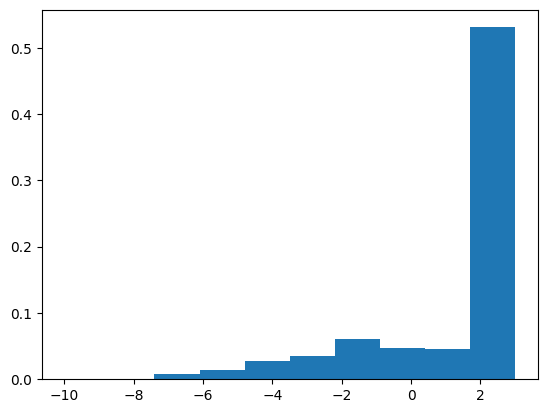

In [ ]:
samples = torch.multinomial(sig_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)

(array([0.001, 0.   , 0.003, 0.006, 0.008, 0.034, 0.05 , 0.136, 0.099,
        0.663]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 10 artists>)

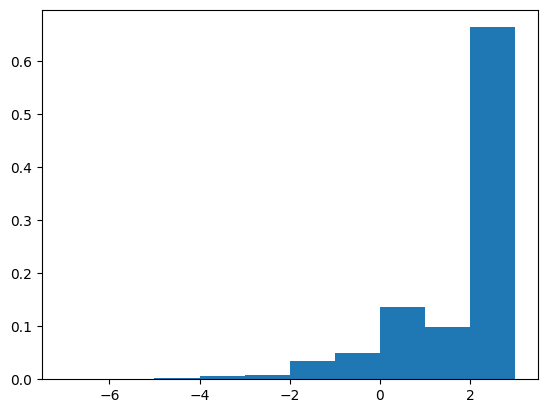

In [ ]:
samples = torch.multinomial(soft_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)